<p style="padding: 10px; border: 1px solid black;">
<img src="../utils/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>



Note: Please use **GPU** for training, CPU training will lead to an unceasing running script.

In [1]:
# # install AutoGluon
# !pip install -q autogluon

# AutoMM for Image Classification



In this quick start, we'll use the task of image classification to illustrate how to use **AutoMMPredictor**. Once the data is prepared in [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) format, a single call to `AutoMMPredictor.fit()` will take care of the model training for you.


## Create Image Dataset

For demonstration purposes, we use a subset of the [Shopee-IET dataset](https://www.kaggle.com/c/shopee-iet-machine-learning-competition/data) from Kaggle.
Each image in this data depicts a clothing item and the corresponding label specifies its clothing category.
Our subset of the data contains the following possible labels: `BabyPants`, `BabyShirt`, `womencasualshoes`, `womenchiffontop`.

We can load a dataset by downloading a url data automatically:

In [2]:
import warnings
warnings.filterwarnings('ignore')
from autogluon.vision import ImageDataset
train_dataset, _, test_dataset = ImageDataset.from_folders("https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip") 
print(train_dataset)

100%|██████████| 40895/40895 [00:01<00:00, 20661.92KB/s]


data/
├── test/
└── train/
                                                 image  label
0    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
1    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
2    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
3    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
4    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
..                                                 ...    ...
795  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
796  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
797  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
798  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
799  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3

[800 rows x 2 columns]


We can see there are 800 rows and 2 columns in this training dataframe. The 2 columns are **image** and **label**, and each row represents a different training sample.


## Use AutoMM to Fit Models

Now, we fit a classifier using AutoMM as follows:

In [3]:
from autogluon.multimodal import AutoMMPredictor
predictor = AutoMMPredictor(label="label", path="../AutogluonModels/MultiModalImage")
predictor.fit(
    train_data=train_dataset,
    time_limit=30, # seconds
) # you can trust the default config, e.g., we use a `swin_base_patch4_window7_224` model

Global seed set to 123
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 86.7 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func         | CrossEntropyLoss                | 0     
----------------------------------------------------------------------
86.7 M    Trainable params
0         Non-trainable params
86.7 M    Total params
173.495   Total estim

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 2: 'val_accuracy' reached 0.33750 (best 0.33750), saving model to '/home/ec2-user/SageMaker/MLU-WKSP-Tuning-Autogluon/notebooks/automm_imgcls/epoch=0-step=2.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 5: 'val_accuracy' reached 0.80625 (best 0.80625), saving model to '/home/ec2-user/SageMaker/MLU-WKSP-Tuning-Autogluon/notebooks/automm_imgcls/epoch=0-step=5.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:38. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

**label** is the name of the column that contains the target variable to predict, e.g., it is "label" in our example. **path** indicates the directory where models and intermediate outputs should be saved. We set the training time limit to 30 seconds for demonstration purpose, but you can control the training time by setting configurations. To customize AutoMM, please refer to [tutorials/multimodal/customization.ipynb](https://github.com/gidler/autogluon-tutorials/blob/main/tutorials/multimodal/customization.ipynb).


## Evaluate on Test Dataset

You can evaluate the classifier on the test dataset to see how it performs, the test top-1 accuracy is:

In [4]:
scores = predictor.evaluate(test_dataset, metrics=["accuracy"])
print('Top-1 test acc: %.3f' % scores["accuracy"])

Predicting: 0it [00:00, ?it/s]

Top-1 test acc: 0.825


## Predict on a New Image

Given an example image, let's visualize it first,

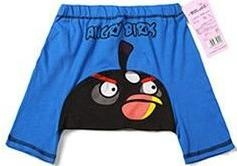

In [5]:
image_path = test_dataset.iloc[0]['image']
from IPython.display import Image, display
pil_img = Image(filename=image_path)
display(pil_img)

We can easily use the final model to `predict` the label,

In [6]:
predictions = predictor.predict({'image': [image_path]})
print(predictions)

Predicting: 0it [00:00, ?it/s]

[0]


If probabilities of all categories are needed, you can call `predict_proba`:

In [7]:
proba = predictor.predict_proba({'image': [image_path]})
print(proba)

Predicting: 0it [00:00, ?it/s]

[[0.3588905  0.2410948  0.13635257 0.26366195]]


## Extract Embeddings

Extracting representation from the whole image learned by a model is also very useful. We provide `extract_embedding` function to allow predictor to return the N-dimensional image feature where `N` depends on the model(usually a 512 to 2048 length vector)

In [8]:
feature = predictor.extract_embedding({'image': [image_path]})
print(feature[0].shape)

Predicting: 0it [00:00, ?it/s]

(1024,)


## Save and Load

The trained predictor is automatically saved at the end of `fit()`, and you can easily reload it.

In [9]:
loaded_predictor = AutoMMPredictor.load('../AutogluonModels/MultiModalImage')
load_proba = loaded_predictor.predict_proba({'image': [image_path]})
print(load_proba)

Load pretrained checkpoint: /home/ec2-user/SageMaker/MLU-WKSP-Tuning-Autogluon/notebooks/automm_imgcls/model.ckpt


Predicting: 0it [00:00, ?it/s]

[[0.3588905  0.2410948  0.13635257 0.26366195]]


We can see the predicted class probabilities are still the same as above, which means same model!

<p style="padding: 10px; border: 1px solid black;">
<img src="../utils/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>

# Thank you!